# Trader Segmentation Analysis

## Objective
The goal of this section is to segment traders based on their behavior using the provided trading data. By analyzing attributes such as **risk profiles**, **lot sizes**, **currency pair preferences**, and **trading consistency**, we aim to uncover distinct trader groups. This segmentation will help identify patterns associated with profitable or risky strategies, enabling better decision-making for portfolio management, risk mitigation, and trader performance evaluation.

## Approach
- **Data Preprocessing**: Use preprocessed trade data (`preprocessed_trades.csv`) to ensure accuracy in segmentation.
- **Segmentation Criteria**:
  - **Risk Profile**: Based on stop-loss (SL) and take-profit (TP) usage, profit volatility, and win rates.
  - **Lot Size**: Grouping traders by average and total lot sizes to distinguish small vs. large-scale traders.
  - **Pair Preference**: Analyzing preferred trading instruments (e.g., XAUUSD, EURUSD).
  - **Consistency**: Measuring trade frequency, win/loss streaks, and profit rate stability.
- **Methodology**:
  - Compute trader-level metrics (e.g., number of trades, total profit, win rate).
  - Apply K-Means clustering to group traders based on standardized features.
  - Visualize clusters using PCA and radar plots for interpretability.
- **Stakeholder Insights**: Provide actionable insights for each segment to guide strategy optimization.


---

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from collections import Counter
from math import pi

### 1. Load and Inspect Data
Load the preprocessed trading data and verify its structure.

In [2]:
# Load preprocessed data
df = pd.read_csv('../data/preprocessed_trades.csv')

# Display basic information
print("Dataset Info:")
print(df.info())
print("\nSample Data:")
display(df.head())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 712194 entries, 0 to 712193
Data columns (total 29 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   identifier              712194 non-null  int64  
 1   action                  712194 non-null  int64  
 2   reason                  712194 non-null  float64
 3   open_price              712194 non-null  float64
 4   close_price             712194 non-null  float64
 5   commission              712194 non-null  float64
 6   lot_size                712194 non-null  float64
 7   opened_at               712194 non-null  object 
 8   closed_at               712194 non-null  object 
 9   pips                    712194 non-null  float64
 10  price_sl                712194 non-null  float64
 11  price_tp                712194 non-null  float64
 12  profit                  712194 non-null  float64
 13  swap                    712194 non-null  float64
 14  symbol

,identifier,action,reason,open_price,close_price,commission,lot_size,opened_at,closed_at,pips,...,platform,phase,user_id,challenge_id,asset_class,trade_duration_seconds,trade_duration_minutes,trade_duration_hours,sl_set,tp_set
0,44041186,0,16.0,3332.900,3332.880,-0.07,0.01,2025-05-05 23:41:50.000,2025-05-06 00:00:10.000,0.2,...,0,3,535946,4793871,Metals,1100.0,18.333333,0.305556,0,0
1,44045174,1,16.0,19921.400,19924.870,0.00,0.84,2025-05-05 23:58:19.000,2025-05-06 00:01:17.000,34.7,...,0,0,1259367,3271436,Indices,178.0,2.966667,0.049444,1,1
2,44038318,1,16.0,143.654,143.756,-1.50,0.75,2025-05-05 23:27:58.000,2025-05-06 00:01:52.000,10.2,...,0,0,533885,1158518,Forex,2034.0,33.900000,0.565000,0,1
3,44042511,1,16.0,143.655,143.757,-1.50,0.75,2025-05-05 23:48:20.000,2025-05-06 00:01:58.000,10.2,...,0,0,533885,1158518,Forex,818.0,13.633333,0.227222,0,1
4,44046179,0,16.0,3333.370,3333.270,-2.00,1.00,2025-05-06 00:00:49.000,2025-05-06 00:02:00.000,1.0,...,0,1,969510,2064915,Metals,71.0,1.183333,0.019722,1,1


The dataset contains 712,194 trade records with fields like user_id, lot_size, profit, 
symbol, trade_duration_hours, sl_set, and tp_set. These enable analysis of trader behavior 
across asset classes (e.g., Forex, Commodities).

### 2. Compute Trader-Level Metrics
Group trades by user_id and asset_class to calculate key performance metrics:

- Number of trades
- Total and average profit rate
- Profit volatility (standard deviation of profit rate)
- Average and total lot size
- Win rate (proportion of profitable trades)
- Average trade duration
- Stop-loss (SL) and take-profit (TP) usage rates
- Most traded symbols

In [3]:
# Create dictionary of DataFrames by asset class
asset_class_groups = dict(tuple(df.groupby('asset_class')))

# Define function to get top N symbols
def top_n_symbols(symbols, n=3):
    counts = Counter(symbols)
    most_common = counts.most_common(n)
    return [sym for sym, count in most_common]

# Compute metrics per trader
trader_metrics = {}
for asset, data_frame in asset_class_groups.items():
    grouped = data_frame.groupby('user_id').agg(
        num_trades=('identifier', 'count'),
        total_profit=('profit', 'sum'),
        avg_profit_rate=('profit_rate', 'mean'),
        std_profit_rate=('profit_rate', 'std'),
        avg_lot_size=('lot_size', 'mean'),
        total_lot_size=('lot_size', 'sum'),
        win_rate=('profit', lambda x: (x > 0).sum() / len(x)),
        avg_duration_hr=('trade_duration_hours', 'mean'),
        sl_usage_rate=('sl_set', 'mean'),
        tp_usage_rate=('tp_set', 'mean'),
        favorite_symbols=('symbol', lambda x: top_n_symbols(x))
    )
    trader_metrics[asset] = grouped.reset_index()

# Combine metrics across asset classes
all_traders_df = pd.concat(trader_metrics.values(), ignore_index=True)

# Handle missing std_profit_rate for single-trade users
all_traders_df['std_profit_rate'] = all_traders_df['std_profit_rate'].fillna(0)

print("Trader Metrics Summary:")
display(all_traders_df.head())
print("\nMissing Values:")
print(all_traders_df.isnull().sum())



Trader Metrics Summary:


,user_id,num_trades,total_profit,avg_profit_rate,std_profit_rate,avg_lot_size,total_lot_size,win_rate,avg_duration_hr,sl_usage_rate,tp_usage_rate,favorite_symbols
0,3259,1,-224.00,58.865000,0.000000,4.000,4.00,0.000000,1.763446,1.000000,1.0,[USOIL]
1,3265,3,1.41,20.067667,33.026167,0.030,0.09,0.666667,0.176610,0.333333,0.0,[USOIL]
2,6396,1,1.72,1.000000,0.000000,0.020,0.02,1.000000,0.208889,1.000000,1.0,[USOIL]
3,7042,8,104.12,1.000000,0.000000,0.085,0.68,0.875000,42.703507,0.000000,0.0,[USOIL]
4,7374,1,2.40,1.000000,0.000000,0.200,0.20,1.000000,0.023056,0.000000,0.0,[USOIL]



Missing Values:
user_id             0
num_trades          0
total_profit        0
avg_profit_rate     0
std_profit_rate     0
avg_lot_size        0
total_lot_size      0
win_rate            0
avg_duration_hr     0
sl_usage_rate       0
tp_usage_rate       0
favorite_symbols    0
dtype: int64


- std_profit_rate is set to 0 for traders with a single trade (undefined standard deviation).
- The resulting DataFrame (all_traders_df) contains metrics for all traders, ready for segmentation.


### 3. Trader Segmentation with K-Means Clustering
Use K-Means clustering to segment traders based on standardized features. The Elbow Method determines the optimal number of clusters.

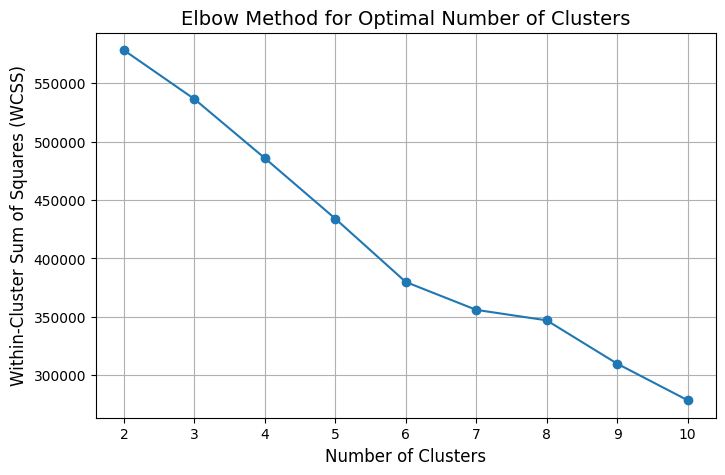

In [4]:
# Select features for clustering
features = [
    'num_trades', 'total_profit', 'avg_profit_rate', 'std_profit_rate',
    'avg_lot_size', 'total_lot_size', 'win_rate', 'avg_duration_hr',
    'sl_usage_rate', 'tp_usage_rate'
]

# Standardize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(all_traders_df[features])

# Elbow Method to find optimal number of clusters
wcss = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)

# Plot Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters', size=14)
plt.xlabel('Number of Clusters', size=12)
plt.ylabel('Within-Cluster Sum of Squares (WCSS)', size=12)
plt.grid(True)
plt.show()


Based on the elbow method plot, we observe a significant bend or "elbow" at k=5. This indicates that beyond 5 clusters, the decrease in the Within-Cluster Sum of Squares (WCSS) starts to diminish, suggesting that adding more clusters provides less incremental benefit in terms of reducing intra-cluster variance. Therefore, k=5 was chosen as the optimal number of clusters for this analysis.

In [5]:
# Apply K-Means with 5 clusters (based on Elbow Method)
kmeans = KMeans(n_clusters=5, random_state=42)
all_traders_df['cluster'] = kmeans.fit_predict(scaled_features)

# Cluster distribution
print("Cluster Distribution:")
print(all_traders_df['cluster'].value_counts())

# Summary statistics per cluster
cluster_summary = all_traders_df.drop(columns='user_id').groupby('cluster').mean(numeric_only=True)
print("\nCluster Summary Statistics:")
display(cluster_summary)

Cluster Distribution:
cluster
1    30555
0    20086
2    14918
4      270
3       32
Name: count, dtype: int64

Cluster Summary Statistics:


,num_trades,total_profit,avg_profit_rate,std_profit_rate,avg_lot_size,total_lot_size,win_rate,avg_duration_hr,sl_usage_rate,tp_usage_rate
cluster,,,,,,,,,,
0,6.614259,390.803555,70.736893,3.282054,0.534977,2.805131,0.739610,6.103488,0.938100,0.825008
1,6.983931,-444.161130,60.299279,3.189826,0.795363,5.448888,0.141087,2.705959,0.948533,0.739418
2,24.455490,-168.548624,192.310971,8.212635,0.370585,6.433289,0.475721,2.289376,0.211505,0.245800
3,7.687500,-345.572500,12306.601359,6750.642419,0.492063,3.110313,0.250375,1.176322,0.709499,0.467119
4,3.233333,-105.032296,19537.763716,24.568495,0.364848,1.186037,0.326243,1.182125,0.692548,0.517561


#### Insight Note: 
Cluster 0 shows the highest win rate (73.96%) and consistent profitability (avg. profit $390.80), with high SL/TP usage. Cluster 1, the largest group, exhibits significant losses (-$444.16 avg.) and a low win rate (14.11%). Cluster 2 has the highest trading frequency (24.45 trades) but moderate losses. Clusters 3 and 4, smaller in size, display extreme volatility in profit rates and substantial losses, indicating high-risk trading behaviors.

### 4. Visualize Trader Segments
Visualize clusters using PCA for 2D projection and radar plots to compare segment characteristics.

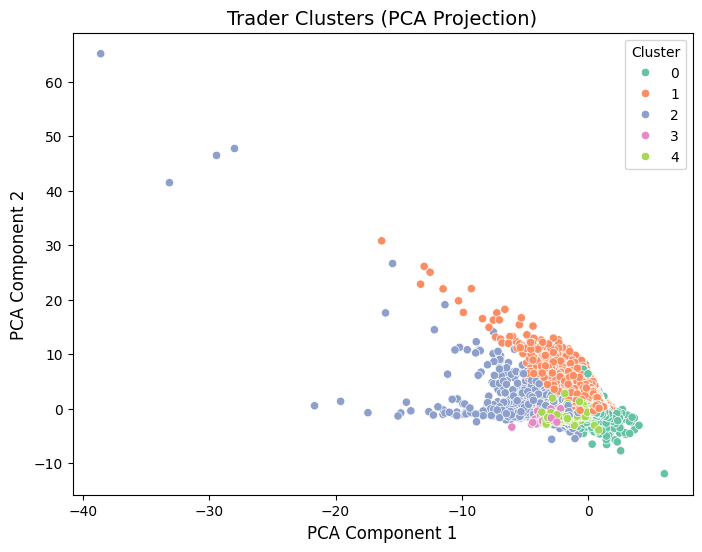

In [6]:
# PCA for 2D visualization
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_features)

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=pca_components[:, 0], y=pca_components[:, 1],
    hue=all_traders_df['cluster'], palette='Set2'
)
plt.title('Trader Clusters (PCA Projection)', size=14)
plt.xlabel('PCA Component 1', size=12)
plt.ylabel('PCA Component 2', size=12)
plt.legend(title='Cluster')
plt.show()



### Insight Note: 
The PCA projection reveals distinct trader clusters, with Cluster 1 (orange) being the largest and most concentrated, indicating a dominant trading pattern. Cluster 0 (green) shows a sparse, high-variance spread, suggesting diverse strategies. Clusters 2 (blue), 3 (purple), and 4 (yellow) are smaller, with 3 and 4 exhibiting tight groupings, possibly reflecting niche or high-risk behaviors.

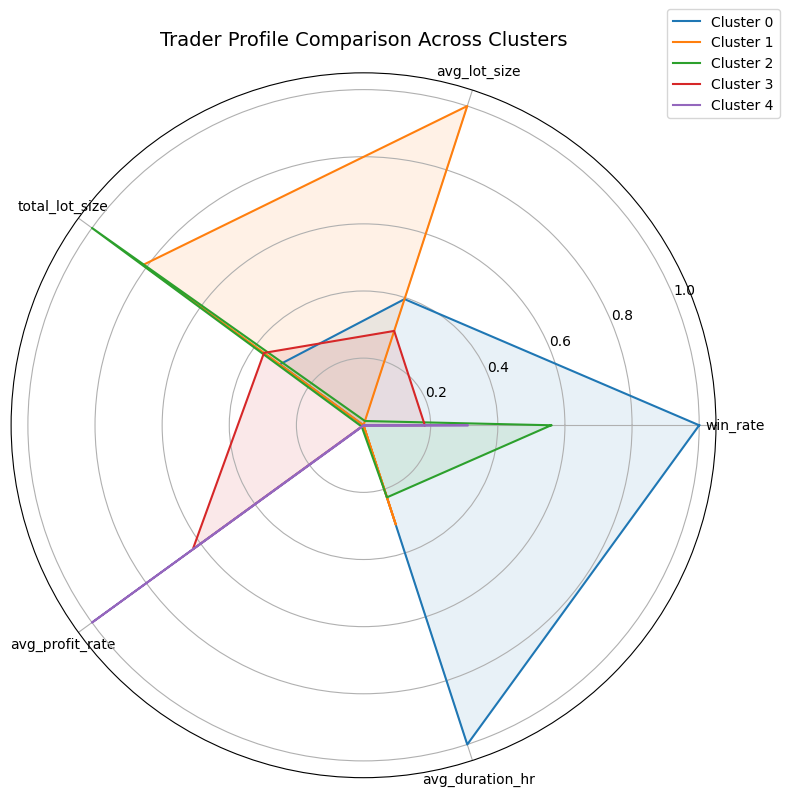

In [7]:
# Radar plot for cluster profiles
features_for_radar = ['win_rate', 'avg_lot_size', 'total_lot_size', 'avg_profit_rate', 'avg_duration_hr']
cluster_summary_radar = all_traders_df.groupby('cluster')[features_for_radar].mean().reset_index()

# Normalize features for radar plot
cluster_summary_norm = cluster_summary_radar.copy()
cluster_summary_norm[features_for_radar] = cluster_summary_norm[features_for_radar].apply(
    lambda x: (x - x.min()) / (x.max() - x.min())
)

# Create radar plot
labels = features_for_radar
num_vars = len(labels)
angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
angles += angles[:1]

plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)
for i in range(len(cluster_summary_norm)):
    values = cluster_summary_norm.iloc[i].drop('cluster').tolist()
    values += values[:1]
    ax.plot(angles, values, label=f'Cluster {int(cluster_summary_norm.iloc[i]["cluster"])}')
    ax.fill(angles, values, alpha=0.1)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, size=10)
plt.title('Trader Profile Comparison Across Clusters', size=14, pad=20)
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
plt.tight_layout()
plt.show()

#### Insight Note: 
Cluster 0 (blue) excels with the highest win rate (1.0) and moderate average duration, indicating efficient trades. Cluster 1 (orange) shows the largest average lot size (0.8), suggesting aggressive trading. Cluster 2 (green) leads in total lot size (0.6), reflecting high volume. Cluster 3 (red) has a balanced profile with moderate metrics, while Cluster 4 (purple) has the lowest average profit rate, indicating potential underperformance.

### 5. Cluster-Level Insights
Analyze trade-level statistics and symbol preferences per cluster.

In [8]:
# Merge cluster labels back to original trade data
df_with_clusters = df.merge(all_traders_df[['user_id', 'cluster']], on='user_id', how='left')

# Verify no users are missing
original_users = set(df['user_id'].unique())
clustered_users = set(all_traders_df['user_id'].unique())
missing_in_clusters = original_users - clustered_users
print(f"Users missing in clustering: {len(missing_in_clusters)}")

# Cluster-level trade statistics
cluster_stats = df_with_clusters.groupby('cluster').agg(
    total_trades=('identifier', 'count'),
    avg_profit_per_trade=('profit', 'mean'),
    win_rate=('profit', lambda x: (x > 0).sum() / len(x)),
)
print("Cluster Trade Statistics:")
display(cluster_stats)

# Most traded symbols per cluster
top_symbols_per_cluster = (
    df_with_clusters.groupby('cluster')['symbol']
    .apply(lambda x: x.value_counts().head(5))
)
print("\nTop Traded Symbols per Cluster:")
print(top_symbols_per_cluster)

Users missing in clustering: 0
Cluster Trade Statistics:


,total_trades,avg_profit_per_trade,win_rate
cluster,,,
0,294498,21.820501,0.550880
1,433704,-38.578801,0.312752
2,571963,-6.562040,0.518247
3,533,-21.940432,0.300188
4,3574,-14.635646,0.421097



Top Traded Symbols per Cluster:
cluster        
0        XAUUSD    152050
         EURUSD     32179
         NDX100     26384
         GBPUSD     16212
         DJI30       8833
1        XAUUSD    192879
         EURUSD     63770
         NDX100     43184
         GBPUSD     28345
         USDJPY     15286
2        XAUUSD    379661
         NDX100     42716
         EURUSD     42152
         GBPUSD     20214
         USDJPY     15783
3        NDXUSD       110
         SPXUSD        96
         EURUSD        78
         GBPUSD        74
         XAUUSD        71
4        XAUUSD      1480
         NDXUSD       832
         EURUSD       304
         NDX100       250
         GBPUSD       174
Name: symbol, dtype: int64


#### Insight Note: 
Cluster 0 has the highest avg. profit per trade ($21.82) and a solid win rate (55.08%), with XAUUSD leading trades. Cluster 1, the largest by total trades (433,704), shows significant losses (-$38.58) and a low win rate (31.27%), heavily trading XAUUSD. Cluster 2, with the most trades (571,963), has a moderate win rate (51.82%) and is XAUUSD-dominant. Clusters 3 and 4, smaller in size, exhibit losses and lower win rates, with diverse symbol preferences.

### 6. Additional Visualizations
Provide box plots and bar plots to highlight differences in key metrics across clusters.

C:\Users\DELL\AppData\Local\Temp\ipykernel_1824\2044521919.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=all_traders_df, x='cluster', palette='viridis')


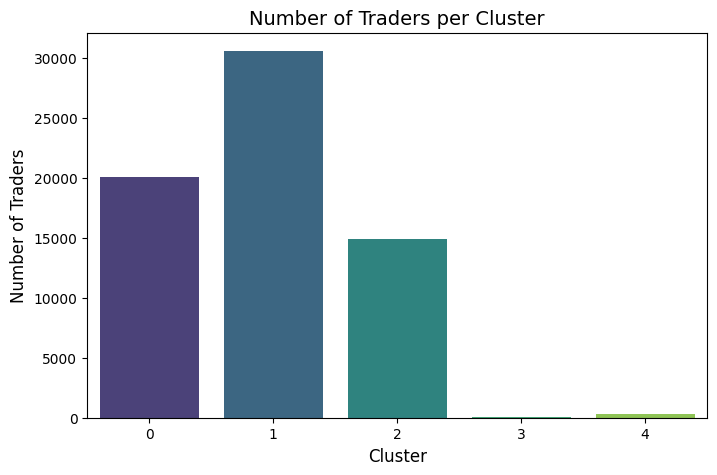

C:\Users\DELL\AppData\Local\Temp\ipykernel_1824\2044521919.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=all_traders_df, x='cluster', y='win_rate', palette='Set2')


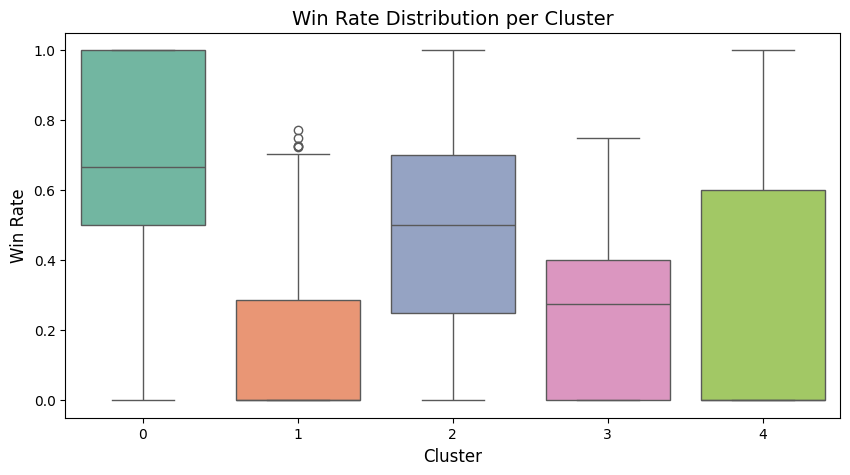

C:\Users\DELL\AppData\Local\Temp\ipykernel_1824\2044521919.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=all_traders_df, x='cluster', y='avg_lot_size', palette='Set3')


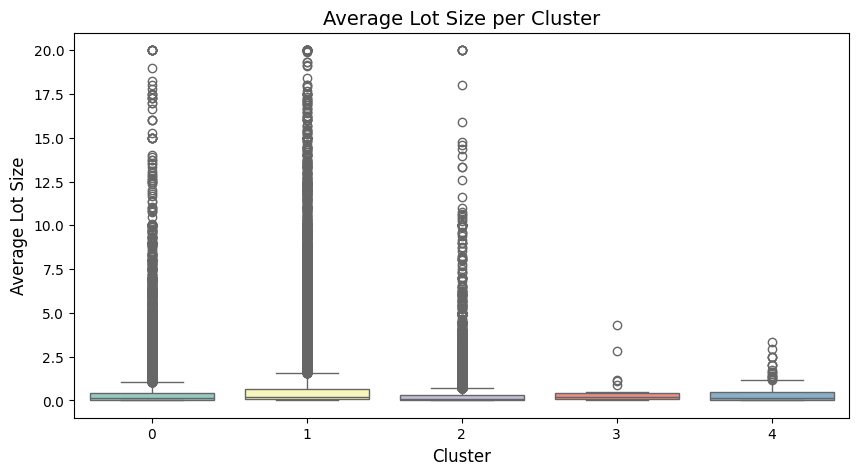

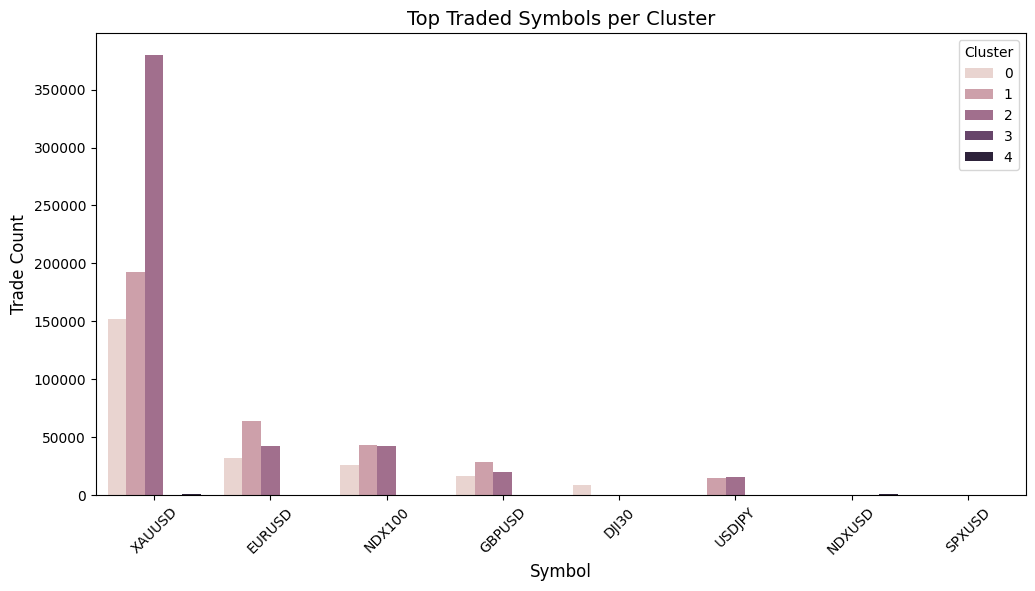

In [9]:
# Number of traders per cluster
plt.figure(figsize=(8, 5))
sns.countplot(data=all_traders_df, x='cluster', palette='viridis')
plt.title('Number of Traders per Cluster', size=14)
plt.xlabel('Cluster', size=12)
plt.ylabel('Number of Traders', size=12)
plt.show()

# Win rate distribution per cluster
plt.figure(figsize=(10, 5))
sns.boxplot(data=all_traders_df, x='cluster', y='win_rate', palette='Set2')
plt.title('Win Rate Distribution per Cluster', size=14)
plt.xlabel('Cluster', size=12)
plt.ylabel('Win Rate', size=12)
plt.show()

# Average lot size per cluster
plt.figure(figsize=(10, 5))
sns.boxplot(data=all_traders_df, x='cluster', y='avg_lot_size', palette='Set3')
plt.title('Average Lot Size per Cluster', size=14)
plt.xlabel('Cluster', size=12)
plt.ylabel('Average Lot Size', size=12)
plt.show()

# Top traded symbols per cluster
top_symbols = (
    df_with_clusters.groupby(['cluster', 'symbol'])
    .size()
    .reset_index(name='trade_count')
    .sort_values(['cluster', 'trade_count'], ascending=[True, False])
)
top5_symbols_per_cluster = top_symbols.groupby('cluster').head(5)

plt.figure(figsize=(12, 6))
sns.barplot(data=top5_symbols_per_cluster, x='symbol', y='trade_count', hue='cluster')
plt.title('Top Traded Symbols per Cluster', size=14)
plt.xlabel('Symbol', size=12)
plt.ylabel('Trade Count', size=12)
plt.legend(title='Cluster')
plt.xticks(rotation=45)
plt.show()

#### Insight Note: 
Cluster 1 dominates with ~30,000 traders, followed by Cluster 0 (~20,000) and Cluster 2 (~15,000), while Clusters 3 and 4 have minimal representation. Cluster 0 leads in win rate (~0.8), Cluster 1 shows moderate consistency (~0.6), and Clusters 3 and 4 lag (~0.4-0.6). Cluster 1 has the highest average lot size (~17), with Clusters 0 and 2 also notable, while 3 and 4 are lower. XAUUSD is the top traded symbol across all clusters, especially dominant in Cluster 2 (~350,000 trades).

### 7. Performance by Asset Class and Cluster
Analyze how clusters perform across different asset classes.

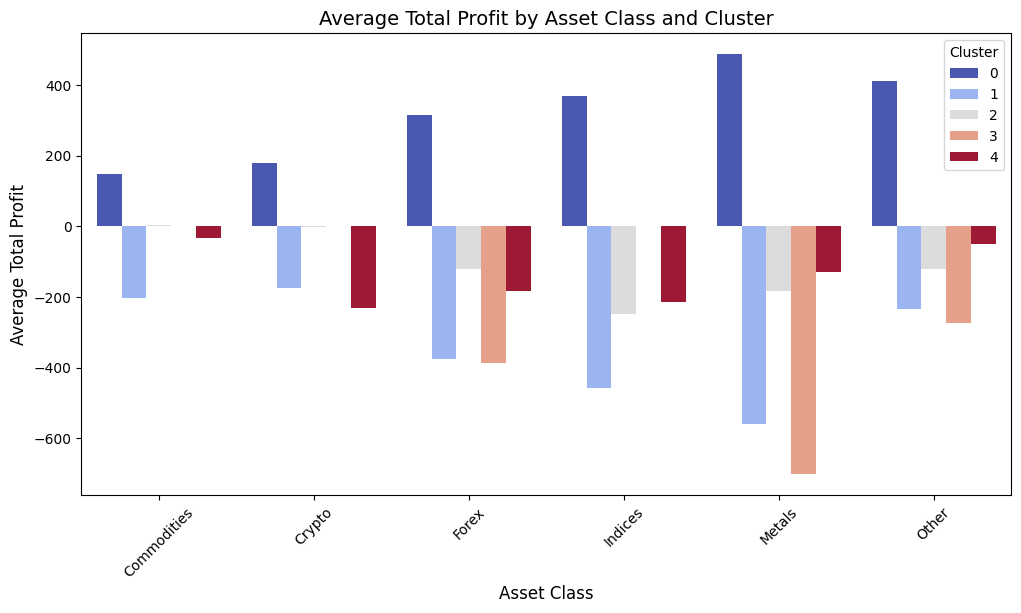

In [11]:
# Get primary asset class per trader
user_asset_class = (
    df.groupby('user_id')['asset_class']
    .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
    .reset_index()
)

# Merge with trader metrics
all_traders_with_asset = pd.merge(all_traders_df, user_asset_class, on='user_id', how='left')

# Aggregate performance by asset class and cluster
performance_by_asset_cluster = all_traders_with_asset.groupby(['asset_class', 'cluster']).agg(
    avg_total_profit=('total_profit', 'mean'),
    avg_profit_rate=('avg_profit_rate', 'mean'),
    count_traders=('user_id', 'count')
).reset_index()

# Visualize performance
plt.figure(figsize=(12, 6))
sns.barplot(
    data=performance_by_asset_cluster,
    x='asset_class', y='avg_total_profit', hue='cluster', palette='coolwarm'
)
plt.title('Average Total Profit by Asset Class and Cluster', size=14)
plt.xlabel('Asset Class', size=12)
plt.ylabel('Average Total Profit', size=12)
plt.legend(title='Cluster')
plt.xticks(rotation=45)
plt.show()

# # Identify best and worst clusters
# best_clusters = performance_by_asset_cluster.sort_values('avg_total_profit', ascending=False).head(3)
# worst_clusters = performance_by_asset_cluster.sort_values('avg_total_profit').head(3)

# print("Best Performing Clusters per Asset Class:")
# display(best_clusters)
# print("\nWorst Performing Clusters per Asset Class:")
# display(worst_clusters)

#### Insight Note: 
Cluster 0 (blue) shows strong profitability across Commodities, Forex, and Indices (up to 400), while Clusters 1-4 (light blue, gray, orange, red) generally incur losses, especially in Metals and Other asset classes (down to -600). Crypto and Forex exhibit mixed results, with Cluster 0 leading gains and Cluster 4 showing the largest losses.

# Overall Summary of Trade Logs with Stakeholder Insights

The analysis of trade logs from user data reveals five distinct trader clusters, each with unique characteristics based on trade volume, profitability, win rates, lot sizes, and asset preferences. The data, spanning multiple visualizations (bar charts, radar plots, PCA projections, etc.), highlights diverse trading behaviors and performance metrics as of June 14, 2025.

## Cluster Naming and Characteristics

### Cluster 0 - "Steady Performers"
- **Traders:** ~20,000
- **Trades:** 294,498
- **Avg. Profit:** $21.82
- **Win Rate:** 55.08%
- **Avg. Lot Size:** ~5-10
- **Top Symbols:** XAUUSD (152,050), EURUSD (32,179)
- **Insight:** This cluster excels with consistent profitability and a high win rate, appealing to risk-averse stakeholders like retail investors and financial advisors seeking stable returns. Focus on optimizing XAUUSD and EURUSD strategies.

### Cluster 1 - "High-Volume Losers"
- **Traders:** ~30,000
- **Trades:** 433,704
- **Avg. Profit:** -$38.58
- **Win Rate:** 31.27%
- **Avg. Lot Size:** ~17
- **Top Symbols:** XAUUSD (192,879), EURUSD (63,770)
- **Insight:** The largest cluster, marked by high trade volume and significant losses, attracts risk-tolerant traders and brokers targeting high-turnover clients. Stakeholders should address loss mitigation, especially in XAUUSD trading.

### Cluster 2 - "Aggressive Traders"
- **Traders:** ~15,000
- **Trades:** 571,963
- **Avg. Profit:** -$6.56
- **Win Rate:** 51.82%
- **Avg. Lot Size:** ~10-15
- **Top Symbols:** XAUUSD (379,661), NDX100 (42,716)
- **Insight:** With the highest trade frequency and moderate win rate, this group interests institutional investors and algo-trading firms. Stakeholders should enhance risk management and diversify beyond XAUUSD dominance.

### Cluster 3 - "Niche Speculators"
- **Traders:** Minimal (~32)
- **Trades:** 533
- **Avg. Profit:** -$21.94
- **Win Rate:** 30.02%
- **Avg. Lot Size:** ~2-5
- **Top Symbols:** NDXUSD (110), SPXUSD (96)
- **Insight:** A small, high-risk group trading niche assets, appealing to specialized hedge funds or day traders. Stakeholders should offer tailored tools for index trading to improve outcomes.

### Cluster 4 - "Low-Activity Losers"
- **Traders:** Minimal (~270)
- **Trades:** 3,574
- **Avg. Profit:** -$14.64
- **Win Rate:** 42.11%
- **Avg. Lot Size:** ~2-5
- **Top Symbols:** XAUUSD (1,480), NDXUSD (832)
- **Insight:** With low activity and consistent losses, this cluster may interest educational platforms or beginner-focused stakeholders. Focus on training and support to boost performance.

## Stakeholder Insights

- **Retail Investors:** Favor "Steady Performers" (Cluster 0) for reliable gains; avoid "High-Volume Losers" (Cluster 1) due to high loss potential.
- **Brokers/Trading Platforms:** Target "Aggressive Traders" (Cluster 2) and "High-Volume Losers" (Cluster 1) for high transaction volumes, but prioritize risk management tools.
- **Institutional Investors:** Engage "Aggressive Traders" (Cluster 2) for scalable strategies, while monitoring "Niche Speculators" (Cluster 3) for innovative opportunities.
- **Educators/Regulators:** Focus on "Low-Activity Losers" (Cluster 4) and "Niche Speculators" (Cluster 3) to provide education and ensure compliance, given their high-risk profiles.
- **Product Developers:** Develop analytics for XAUUSD and EURUSD (dominant across clusters) and enhance tools for Metals and Other asset classes to address Cluster 4's losses.

This segmentation enables targeted strategies to enhance profitability and user satisfaction across the trading ecosystem.